# DSCI552: HW2
### Alain Tamazian
### ID#: 2073746513

---------------
## 1.a
Combined Cycle Power Plant Data Set

In [1]:
# Cell for all imports necessary for HW1

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from warnings import simplefilter
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import OLSInfluence
from sklearn.preprocessing import PolynomialFeatures
import statsmodels.formula.api as smf
from sklearn.metrics import mean_squared_error
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import MinMaxScaler
# had to chance its name since I have variables named "distance"
from scipy.spatial import distance as distan


In [2]:
file = "../data/CCPP/Folds5x2_pp.xlsx"
ccpp_df = pd.read_excel(file)


--------------
## 1.b.i
(b) Exploring the data:

i. How many rows are in this data set? How many columns? What do the rows and columns represent?

In [3]:
pd.set_option('display.max_rows', 10)
# uncomment the line below if you want all rows of data displayed instead of just a sample of 10
# pd.set_option('display.max_rows', None)

display(ccpp_df)
print("There are", ccpp_df.shape[0], "rows.")
print("There are", ccpp_df.shape[1], "columns.")


AT      V       AP     RH      PE
0     14.96  41.76  1024.07  73.17  463.26
1     25.18  62.96  1020.04  59.08  444.37
2      5.11  39.40  1012.16  92.14  488.56
3     20.86  57.32  1010.24  76.64  446.48
4     10.82  37.50  1009.23  96.62  473.90
...     ...    ...      ...    ...     ...
9563  16.65  49.69  1014.01  91.00  460.03
9564  13.19  39.18  1023.67  66.78  469.62
9565  31.32  74.33  1012.92  36.48  429.57
9566  24.48  69.45  1013.86  62.39  435.74
9567  21.60  62.52  1017.23  67.87  453.28

[9568 rows x 5 columns]

There are 9568 rows.
There are 5 columns.


>The dataset contains 9568 rows that represent data points (ie observations) collected from a Combined Cycle Power Plant over 6 years (2006-2011), when the power plant was set to work with full load. 

>The dataset has 5 columns, 4 of which are features consisting of hourly average ambient variables: Temperature (AT), Ambient Pressure (AP), Relative Humidity (RH) and Exhaust Vacuum (V). The fifth column  is the net hourly electrical energy output (PE) of the plant, which is predicted based on the features.

>Most of this answer is verbatim from the provided homework description (as well as the downloaded readme.txt file). 

---------------
## 1.b.ii
(b) Exploring the data:

ii. Make pairwise scatterplots of all the varianbles in the data set including the predictors (independent variables) with the dependent variable. Describe your findings.

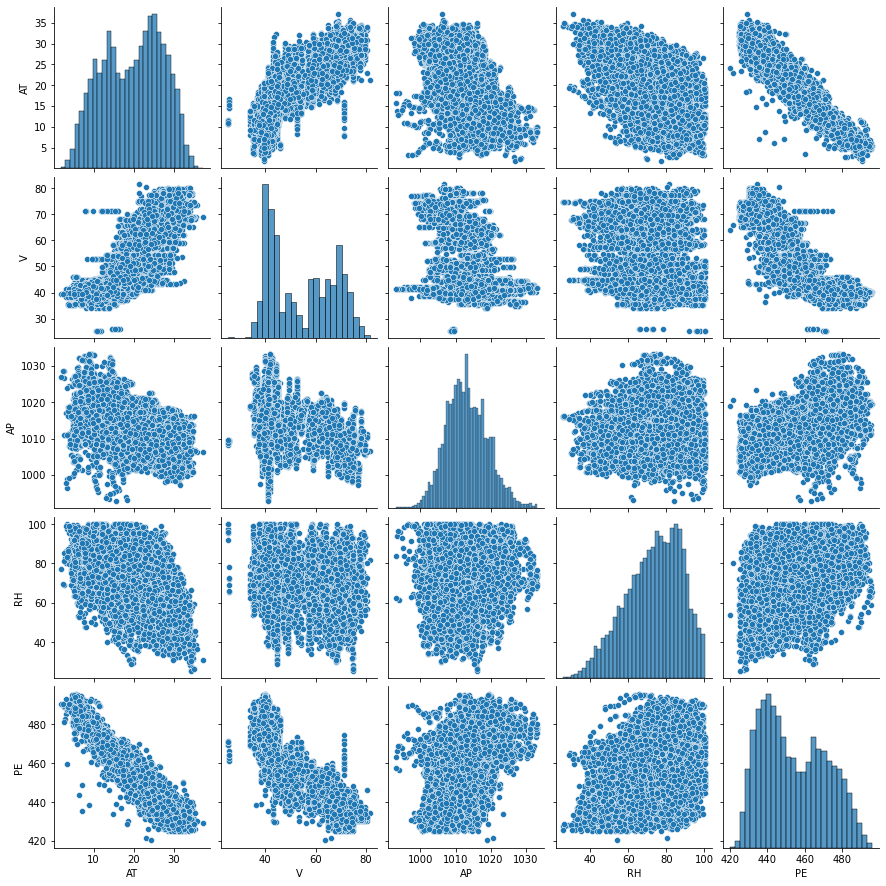

In [4]:
# https://seaborn.pydata.org/generated/seaborn.pairplot.html
# using the seaborn.pairplot() function to make the scatterplots

pairplot = sns.pairplot(ccpp_df, kind="scatter")
# pairplot = sns.pairplot(ccpp_df, kind="reg", plot_kws={"line_kws":{"color": "red"}})
plt.show()


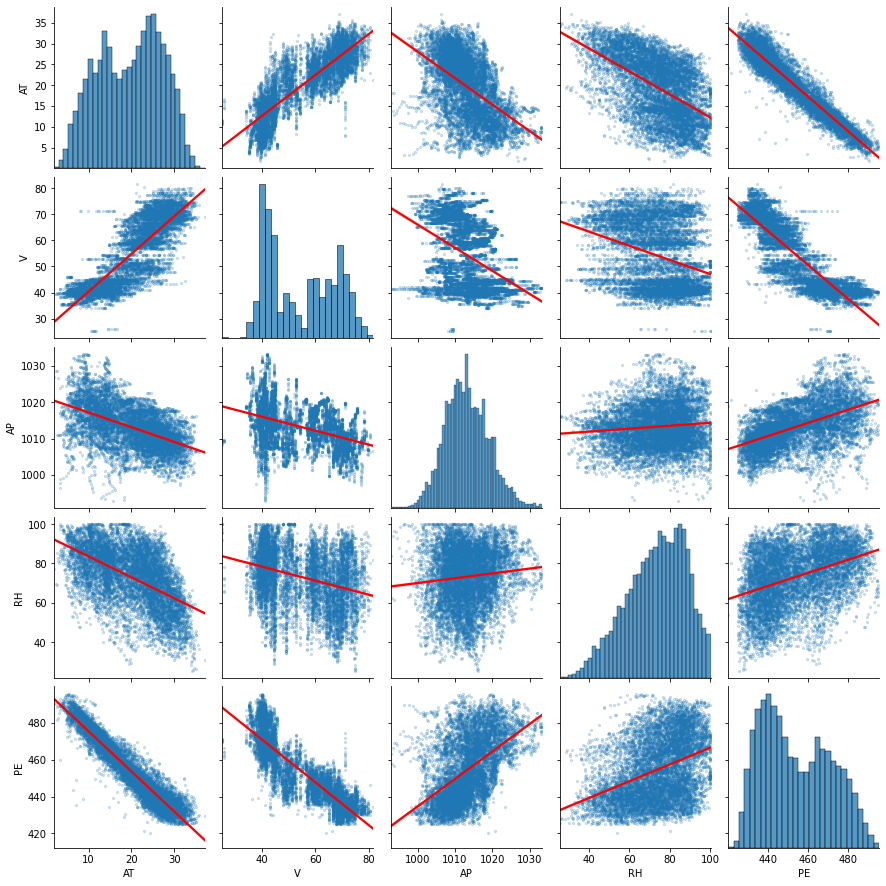

In [5]:
pairplot = sns.pairplot(ccpp_df, kind="reg", plot_kws={"line_kws":{"color":"red"}, "scatter_kws": {'s': 5, "alpha": 0.2}})
plt.show()


The question asks for a "scatterplot", I wasn't sure if a regression scatterplot is acceptable since its "kind" is technically "reg" not "scatter". However, the pairwise reg line is helpful for interpretation, so I included both types to be safe.

>AT and V are positively correlated.

>AT and the other 3 variables are negatively correlated.

>AP and RH have vey little correlation with any of the other variables.

>PE is predicted to be negatively correlated with AT and (slightly les with) V.

>PE is predicted to be positively correlated with AP and (slighly less with) RH.

--------------
## 1.b.iii
(b) Exploring the data:

iii. What are the mean, the median, range, first and third quartiles, and in- terquartile ranges of each of the variables in the dataset? Summarize them in a table.

In [6]:
summary_df = ccpp_df.describe()
# display(summary_df)

rangeL = []
iqrL = []

columnsL = list(ccpp_df.columns)

# calculating range and iqr of all variables
for col in columnsL:
#     https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.iloc.html
    rang = summary_df.iloc[7][col] - summary_df.iloc[3][col]
    rangeL.append(rang)
    iqr = summary_df.iloc[6][col] - summary_df.iloc[4][col]
    iqrL.append(iqr)

# adding new rows
summary_df.loc[len(summary_df.index)] = rangeL 
summary_df.loc[len(summary_df.index)] = iqrL 

summary_df = summary_df.rename(index = {"25%": "Q1", "50%": "median", "75%": "Q3", 8: "range", 9:"IQR"})
display(summary_df)


AT            V           AP           RH           PE
count   9568.000000  9568.000000  9568.000000  9568.000000  9568.000000
mean      19.651231    54.305804  1013.259078    73.308978   454.365009
std        7.452473    12.707893     5.938784    14.600269    17.066995
min        1.810000    25.360000   992.890000    25.560000   420.260000
Q1        13.510000    41.740000  1009.100000    63.327500   439.750000
median    20.345000    52.080000  1012.940000    74.975000   451.550000
Q3        25.720000    66.540000  1017.260000    84.830000   468.430000
max       37.110000    81.560000  1033.300000   100.160000   495.760000
range     35.300000    56.200000    40.410000    74.600000    75.500000
IQR       12.210000    24.800000     8.160000    21.502500    28.680000

------------
## 1.c 
(c) For each predictor, fit a simple linear regression model to predict the response. Describe your results. In which of the models is there a statistically significant association between the predictor and the response? Create some plots to back up your assertions. Are there any outliers that you would like to remove from your data for each of these regression tasks?

Simple Linear Regression results between independent variable AT and dependent variable PE


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     PE   R-squared:                       0.899
Model:                            OLS   Adj. R-squared:                  0.899
Method:                 Least Squares   F-statistic:                 8.510e+04
Date:                Fri, 24 Sep 2021   Prob (F-statistic):               0.00
Time:                        16:50:20   Log-Likelihood:                -29756.
No. Observations:                9568   AIC:                         5.952e+04
Df Residuals:                    9566   BIC:                         5.953e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        497.0341      0.156   3177.280      0.000     496.727     497.341
AT            -2.1713      0.007   -291.715      0.000      -2.186      -2.157
==============================================================================
Omnibus:                      417.457   Durbin-Watson:                   2.033
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1117.844
Skew:                          -0.209   Prob(JB):                    1.83e-243
Kurtosis:                       4.621   Cond. No.                         59.4
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

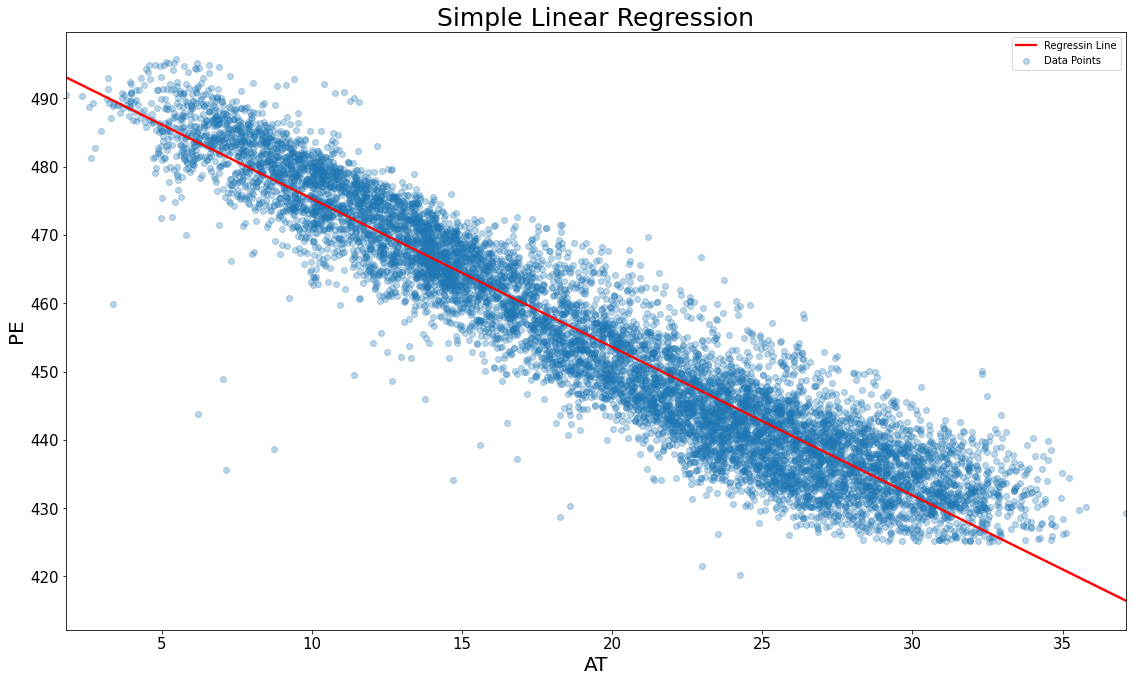

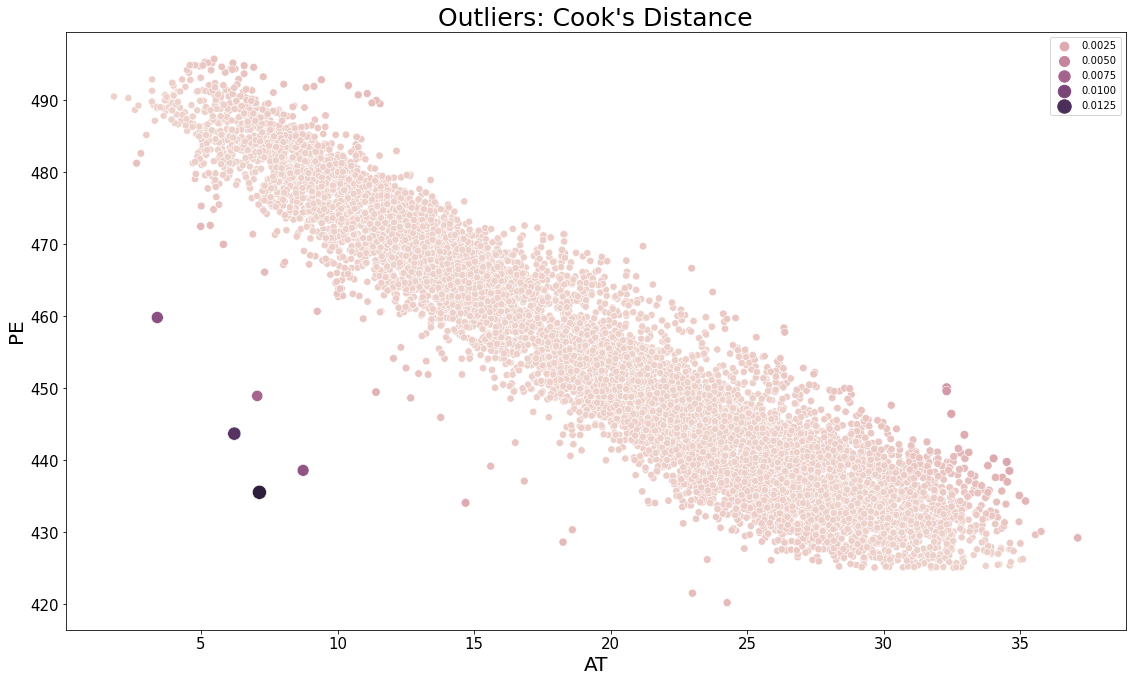

There are 416 outliers — 
based on Cook's Distance with threshold of 4/n = 4/9568 = 0.0004180602006688963


AT      PE  Cook's Dist.
Index                             
21      5.41  495.24      0.000819
61     29.01  446.22      0.000679
87     32.72  437.99      0.001043
89     35.56  429.69      0.000962
121    27.54  450.22      0.000635
...      ...     ...           ...
9452   33.20  438.12      0.001328
9475   30.26  442.98      0.000730
9477   34.03  440.29      0.002467
9542    5.01  475.34      0.001010
9559   26.22  454.20      0.000627

[416 rows x 3 columns]



There are 0 outliers — based on the IQR method.


There are 42 outliers — based on the studentized residual method.


AT      PE  Stud. Res.
Index                           
0      14.96  463.26    3.455406
1      25.18  444.37   -3.098465
2       5.11  488.56    3.428586
3      20.86  446.48    3.329827
4      10.82  473.90    3.252832
...      ...     ...         ...
37     16.38  450.69   -5.300365
38     13.91  469.02    4.201450
39     23.18  448.86   -5.500917
40     22.47  447.14   -4.442125
41     13.39  469.18    3.162413

[42 rows x 3 columns]


-------------------------------------------------------------------------

Simple Linear Regression results between independent variable V and dependent variable PE


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     PE   R-squared:                       0.757
Model:                            OLS   Adj. R-squared:                  0.756
Method:                 Least Squares   F-statistic:                 2.972e+04
Date:                Fri, 24 Sep 2021   Prob (F-statistic):               0.00
Time:                        16:50:32   Log-Likelihood:                -33963.
No. Observations:                9568   AIC:                         6.793e+04
Df Residuals:                    9566   BIC:                         6.794e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        517.8015      0.378   1370.218      0.000     517.061     518.542
V             -1.1681      0.007   -172.402      0.000      -1.181      -1.155
==============================================================================
Omnibus:                       77.693   Durbin-Watson:                   2.007
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              109.571
Skew:                          -0.097   Prob(JB):                     1.61e-24
Kurtosis:                       3.487   Cond. No.                         245.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

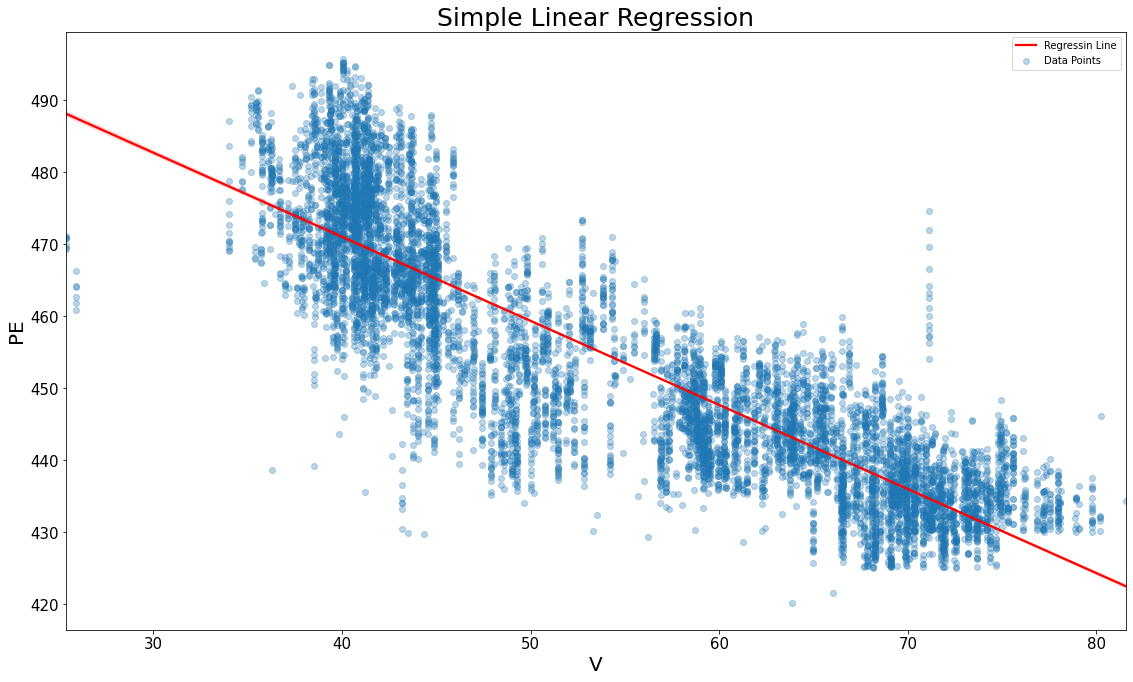

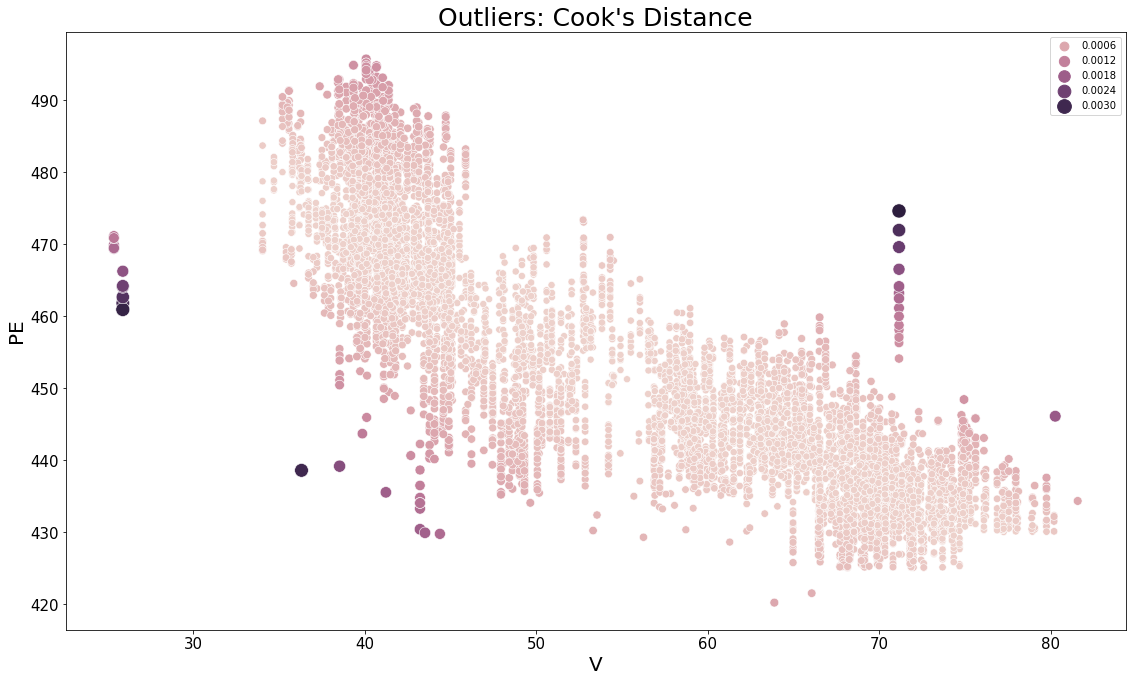

There are 423 outliers — 
based on Cook's Distance with threshold of 4/n = 4/9568 = 0.0004180602006688963


V      PE  Cook's Dist.
Index                             
2      39.40  488.56      0.000493
21     40.07  495.24      0.000977
24     48.60  436.06      0.000552
47     43.43  448.06      0.000461
57     39.33  491.49      0.000679
...      ...     ...           ...
9359   75.23  443.78      0.000525
9394   39.72  455.58      0.000428
9404   44.89  445.45      0.000453
9471   43.77  446.05      0.000529
9509   25.36  470.90      0.001363

[423 rows x 3 columns]



There are 0 outliers — based on the IQR method.


There are 33 outliers — based on the studentized residual method.


V      PE  Stud. Res.
Index                           
0      41.76  463.26    3.786100
1      62.96  444.37   -3.239547
2      39.40  488.56   -3.992615
3      57.32  446.48    4.432613
4      37.50  473.90    3.146028
...      ...     ...         ...
28     35.79  484.41   -3.403588
29     65.18  437.89    3.502890
30     63.94  445.11   -3.106074
31     58.41  438.86    3.304220
32     66.85  440.98   -3.153297

[33 rows x 3 columns]


-------------------------------------------------------------------------

Simple Linear Regression results between independent variable AP and dependent variable PE


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     PE   R-squared:                       0.269
Model:                            OLS   Adj. R-squared:                  0.269
Method:                 Least Squares   F-statistic:                     3516.
Date:                Fri, 24 Sep 2021   Prob (F-statistic):               0.00
Time:                        16:50:44   Log-Likelihood:                -39224.
No. Observations:                9568   AIC:                         7.845e+04
Df Residuals:                    9566   BIC:                         7.847e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -1055.2610     25.459    -41.449      0.000   -1105.167   -1005.355
AP             1.4899      0.025     59.296      0.000       1.441       1.539
==============================================================================
Omnibus:                      525.438   Durbin-Watson:                   1.996
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              612.290
Skew:                           0.616   Prob(JB):                    1.10e-133
Kurtosis:                       2.859   Cond. No.                     1.73e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.73e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

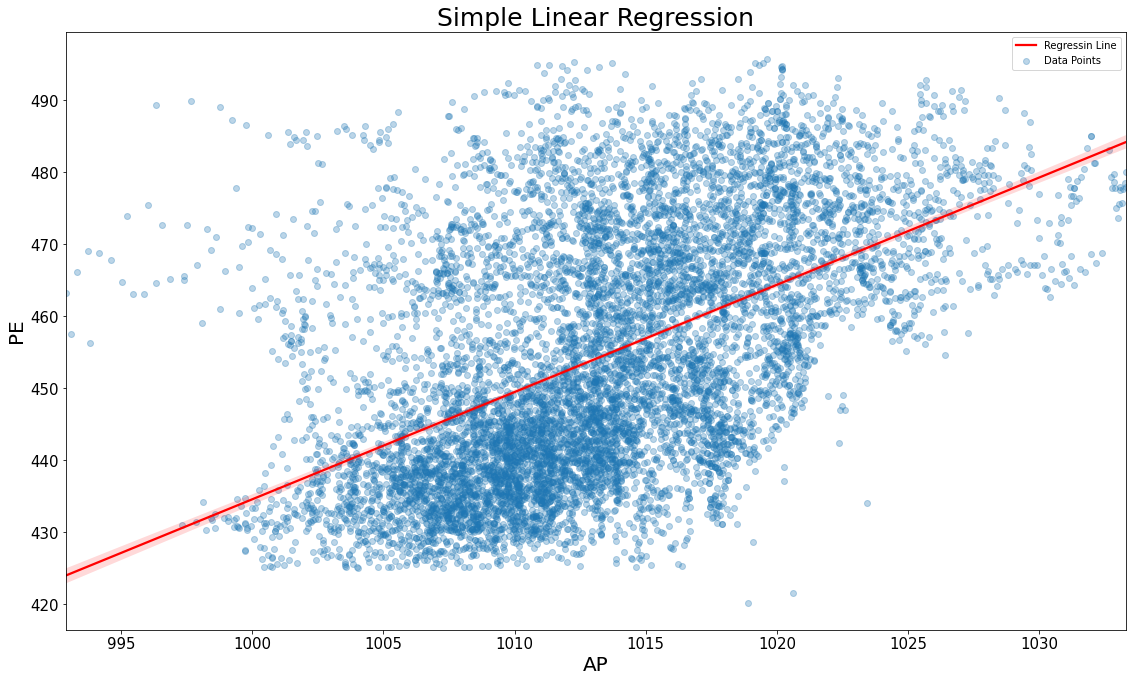

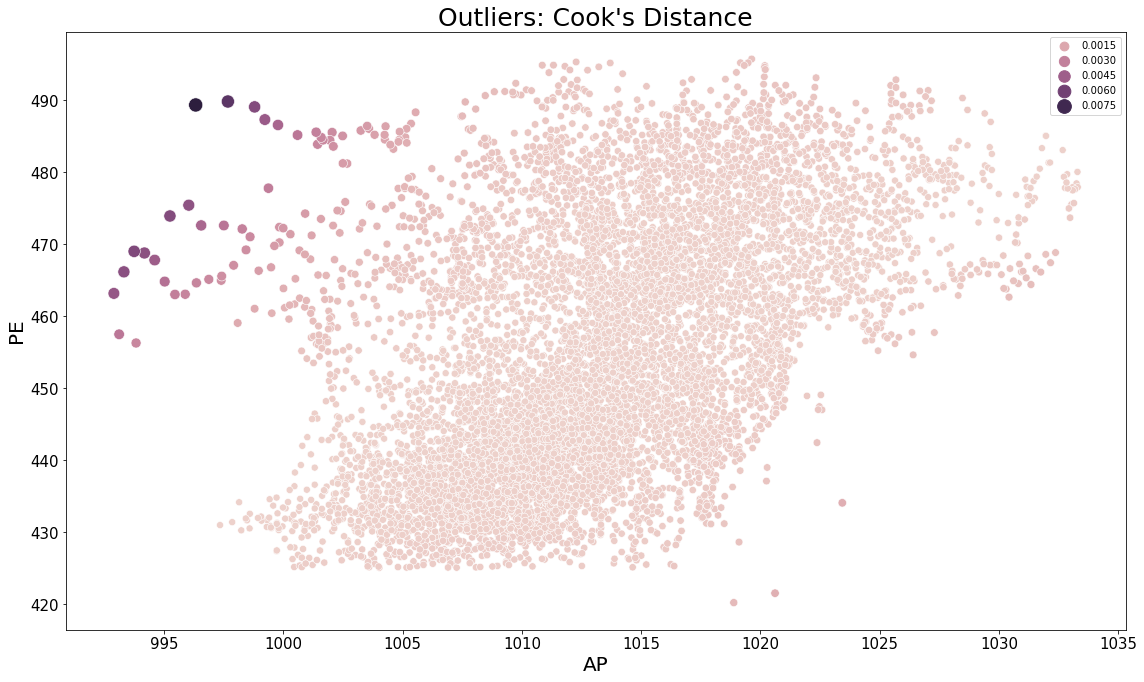

There are 300 outliers — 
based on Cook's Distance with threshold of 4/n = 4/9568 = 0.0004180602006688963


AP      PE  Cook's Dist.
Index                               
21     1019.16  495.24      0.000502
22     1008.52  483.80      0.000535
57     1010.18  491.49      0.000542
74     1008.82  481.09      0.000425
114    1001.24  459.36      0.000656
...        ...     ...           ...
9366   1030.61  464.95      0.000546
9459   1008.43  484.75      0.000576
9483   1005.24  479.22      0.000939
9521    998.27  472.16      0.002916
9542   1003.69  475.34      0.001096

[300 rows x 3 columns]



There are 88 outliers — based on the IQR method.


AP      PE
Index                 
0      1024.07  463.26
1      1020.04  444.37
2      1012.16  488.56
3      1010.24  446.48
4      1009.23  473.90
...        ...     ...
83     1024.42  465.48
84     1014.93  441.34
85     1012.53  441.83
86     1019.00  464.70
87     1009.60  437.99

[88 rows x 2 columns]



There are 30 outliers — based on the studentized residual method.


AP      PE  Stud. Res.
Index                             
0      1024.07  463.26    3.180763
1      1020.04  444.37    3.185185
2      1012.16  488.56    4.133681
3      1010.24  446.48    3.588967
4      1009.23  473.90    3.285757
...        ...     ...         ...
25     1009.97  443.25    4.028179
26     1011.11  464.16    3.696834
27     1023.57  475.52    3.356418
28     1012.14  484.41    3.037249
29     1012.69  437.89    3.408836

[30 rows x 3 columns]


-------------------------------------------------------------------------

Simple Linear Regression results between independent variable RH and dependent variable PE


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     PE   R-squared:                       0.152
Model:                            OLS   Adj. R-squared:                  0.152
Method:                 Least Squares   F-statistic:                     1714.
Date:                Fri, 24 Sep 2021   Prob (F-statistic):               0.00
Time:                        16:50:56   Log-Likelihood:                -39933.
No. Observations:                9568   AIC:                         7.987e+04
Df Residuals:                    9566   BIC:                         7.988e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        420.9618      0.823    511.676      0.000     419.349     422.574
RH             0.4557      0.011     41.399      0.000       0.434       0.477
==============================================================================
Omnibus:                      772.278   Durbin-Watson:                   1.998
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              319.245
Skew:                           0.231   Prob(JB):                     4.75e-70
Kurtosis:                       2.234   Cond. No.                         383.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

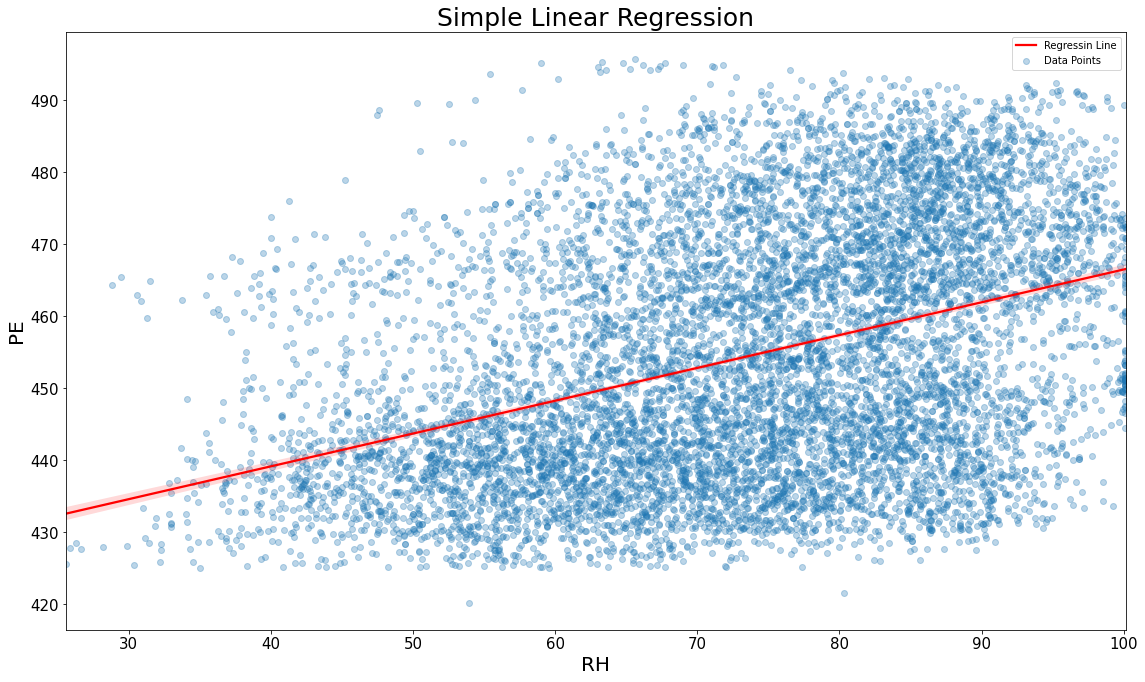

There are 249 outliers — 
based on Cook's Distance with threshold of 4/n = 4/9568 = 0.0004180602006688963


RH      PE  Cook's Dist.
Index                             
8      41.25  475.98      0.001618
15     43.08  462.19      0.000522
16     48.84  467.54      0.000477
21     64.77  495.24      0.000569
48     50.00  474.60      0.000715
...      ...     ...           ...
9124   97.21  490.68      0.000504
9204   98.84  490.50      0.000516
9361   90.20  430.55      0.000491
9469   93.39  434.11      0.000529
9495   99.27  433.62      0.000935

[249 rows x 3 columns]



There are 12 outliers — based on the IQR method.


RH      PE
Index               
0      73.17  463.26
1      59.08  444.37
2      92.14  488.56
3      76.64  446.48
4      96.62  473.90
...      ...     ...
7      66.43  478.42
8      41.25  475.98
9      70.72  477.50
10     75.04  453.02
11     64.22  453.99

[12 rows x 2 columns]



There are 2 outliers — based on the studentized residual method.


RH      PE  Stud. Res.
Index                           
0      73.17  463.26    3.015318
1      59.08  444.37    3.023530


-------------------------------------------------------------------------



In [7]:
# https://www.statsmodels.org/stable/regression.html
# https://www.statsmodels.org/stable/generated/statsmodels.regression.linear_model.OLS.html

# This dictionary/list and any related code is solely to use in 1.e 
coefficientsD = {}
coef_simpL = []

trainX_AT = ccpp_df["AT"]
trainX_V = ccpp_df["V"]
trainX_AP = ccpp_df["AP"]
trainX_RH = ccpp_df["RH"]
trainY_PE = ccpp_df["PE"]

trainX_list = [trainX_AT, trainX_V, trainX_AP, trainX_RH]

for trainX in trainX_list:
    print("Simple Linear Regression results between independent variable", trainX.name, "and dependent variable", trainY_PE.name)
    
    # adding an intercept 
    trainX_const = sm.add_constant(trainX, prepend=True)

    # creating linear regression model
    model = sm.OLS(trainY_PE, trainX_const)
    results = model.fit()
    display(results.summary())
    
    coef = round(results.params[1], 5)
    coefficientsD[trainX.name] = coef
    coef_simpL.append(coef)

    # https://seaborn.pydata.org/generated/seaborn.regplot.html
    # https://medium.com/@kathy.lu.rentals/visualizing-with-seaborn-regplot-2235ccbaedd4
    
    # setting plot size
    fig, ax = plt.subplots()
    fig.set_size_inches(19, 11)
    # Creating a regression scatterplot for the dependent and independent variables
    # "Setting a value for alpha can help us visualize the amount of overlap."
    reg_plot = sns.regplot(x=trainX, y=trainY_PE, scatter_kws={"alpha": 0.3}, line_kws={"color": "red"}, ax=ax)
    # Didn't use predict(trainX) becasue the regplot function automatically take the prediction of the x variable
    plt.title("Simple Linear Regression", fontsize=25)
    reg_plot.set_xlabel(trainX.name, fontsize=20)
    reg_plot.set_ylabel(trainY_PE.name, fontsize=20)
    reg_plot.tick_params(labelsize=15)
    plt.legend(labels=["Regressin Line","Data Points"])
    plt.show()
#     print("\n")
    
    

    # code to ignore all future warnings
    simplefilter(action="ignore", category=FutureWarning)
    # action = "default" to return to normal
    
    # https://medium.com/swlh/identify-outliers-with-pandas-statsmodels-and-seaborn-2766103bf67c
    cook_distance = OLSInfluence(results).cooks_distance
    (distance, p_value) = cook_distance

    # setting plot size
    fig, ax = plt.subplots()
    fig.set_size_inches(19, 11)

    # by setting hue and distance to the distance variable from cook_distance, we can identify outlier by color and size
    # the large/darker the datapoint, the greater it's Cook's Distance (ie the more of an outlier it is)
    sns.scatterplot(trainX, trainY_PE, hue=distance, size=distance, sizes=(50, 200), ax=ax)

    plt.tick_params(labelsize=15)
    plt.xlabel(trainX.name, fontsize=20)
    plt.ylabel(trainY_PE.name, fontsize=20)
    plt.title("Outliers: Cook's Distance", fontsize=25)

    plt.show()

    # number of rows (ie total observations)
    n = ccpp_df.shape[0]

    # Threshold above which, an observation is considered an outlier -- per its Cook's Distance
    # There are multiple approaches/opinions on what threshold to use to identify an indfuential observation; 4/n is a widely used standard
    threshold = 4/n
    outliers = distance[distance > threshold]

    outliers_df = pd.DataFrame(outliers, columns=["Cook's Dist.",])
    outliers_df.index.name = "Index"
    trainX_df = pd.DataFrame(trainX)
    trainX_df.index.name = "Index"
    trainY_df = pd.DataFrame(trainY_PE)
    trainY_df.index.name = "Index"
    
    trainXY_df = pd.merge(trainX_df, trainY_df, left_on="Index", right_index=True)
    outliers_df = pd.merge(trainXY_df, outliers_df, left_on="Index", right_index=True)
    print("There are", outliers_df.shape[0], "outliers — \nbased on Cook's Distance with threshold of 4/n = 4/" + str(n), "=", str(threshold))
    display(outliers_df)
    
    
    # detecting significant outliers using the IQR method; suggested to try by a TA
    # however, this method might be considered a little simplistic
    q1 = trainX.quantile(.25)
    q3 = trainX.quantile(.75)
    iqr = q3-q1
    threshold_max = q3 + 1.5*iqr
    threshold_min = q1 - 1.5*iqr
    
    sig_outliers = [obs for obs in trainX if (obs > threshold_max) or (obs < threshold_min)]
    sig_outliers_df = pd.DataFrame(sig_outliers, columns=["IQR Method",])
    sig_outliers_df.index.name = "Index"
    sig_outliers_df = pd.merge(trainXY_df, sig_outliers_df, left_on="Index", right_index=True)
    sig_outliers_df = sig_outliers_df.drop("IQR Method", axis=1)
    print("\n\nThere are", len(sig_outliers), "outliers — based on the IQR method.")
    if sig_outliers:
        display(sig_outliers_df)
    
    
    # Outliers based on studentized residuals method
    stud_res = results.outlier_test()
    stud_res_df = stud_res.student_resid
    # We consider any studentized residual with an absolute value greater than 3 as an outlier
    sr_outliers = [sr for sr in stud_res_df if abs(sr) > 3]
    sr_outliers_df = pd.DataFrame(sr_outliers, columns=["Stud. Res.",])
    sr_outliers_df.index.name = "Index"
    sr_outliers_df = pd.merge(trainXY_df, sr_outliers_df, left_on="Index", right_index=True)
    print("\n\nThere are", len(sr_outliers), "outliers — based on the studentized residual method.")
    if sr_outliers:
        display(sr_outliers_df)
    print("\n-------------------------------------------------------------------------\n")
    
    

Describe your results. In which of the models is there a statistically significant association between the predictor and the response? Create some plots to back up your assertions. Are there any outliers that you would like to remove from your data for each of these regression tasks?


Simple Linear Regression between independent variable AT and dependent variable PE
>The variable AT has a coefficient of -2.1713 <br>
><b>It has a p-value of ~0.000; <br>
>Since ~0.000 < 0.05 (which is a common standard for the significance level), we can say that there is a statistically significant (negative) association between the predictor (AT) and the response variable (PE).</b> <br>
>So, or every 1 unit increase in Temperature (AT), the electrical energy output (PE) is predicted to decrease by ~2.1713 units. <br>
>The intercept is also statistically significant with a p-value of ~0.000 and a coefficient of 497.034. <br>
>This regression has an R² of ~0.899, which is considered good. This would mean that the model with independent variable AT explains almost 90% of the variance in our data (for response variable PE). As we had seen before, there is a high level of correlation.

>There are 416 outliers — based on Cook's Distance with threshold of  4/9568. Visually, based on the Cook's distance scatterplot, there appear to be about 5 data points that are more significant/influential as outliers (ie with a higher distance). <br>
>There are 0 outliers — based on the IQR method. <br>
>There are 42 outliers — based on the studentized residual method.

>For more information, look at it's OLS Regression Results summary, diagrams, and table(s) outputted above. 

Simple Linear Regression between independent variable V and dependent variable PE
>The variable V has a coefficient of -1.1681 <br>
><b>It has a p-value of ~0.000; <br>
>Since ~0.000 < 0.05 (which is a common standard for the significance level), we can say that there is a statistically significant (negative) association between the predictor (V) and the response variable (PE).</b> <br>
>So, for every 1 unit increase in the Exhaust Vacuum (V), the electrical energy output (PE) is predicted to decrease by ~1.1681 units. <br>
>The intercept is also statistically significant with a p-value of ~0.000 and a coefficient of 517.8015. <br>
>This regression has an R² of ~0.757, which is fairly good. This would mean that the model with independent variable V explains almost 76% of the variance in our data (for response variable PE). Although not as high as for AP, this is still generally interpretted as a high level of correlation.

>There are 423 outliers — based on Cook's Distance with threshold of  4/9568. Visually, based on the Cook's distance scatterplot, there appear to be about two dozen data points that are more significant/influential as outliers (ie with a higher distance). <br>
>There are 0 outliers — based on the IQR method. <br>
>There are 33 outliers — based on the studentized residual method.

>For more information, look at it's OLS Regression Results summary, diagrams, and table(s) outputted above. 

Simple Linear Regression between independent variable AP and dependent variable PE
>The variable AP has a coefficient of 1.4899 <br>
><b>It has a p-value of ~0.000; <br>
>Since ~0.000 < 0.05 (which is a common standard for the significance level), we can say that there is a statistically significant (positive) association between the predictor (AP) and the response variable (PE).</b> <br>
>So, for every 1 unit increase in the Ambient Pressure (AP), the electrical energy output (PE) is predicted to increase by ~1.4899 units. <br>
>The intercept is also statistically significant with a p-value of ~0.000 and a coefficient of -1055.261. <br>
>This regression has an R² of ~0.269, which is low. This would mean that the model with independent variable AP explains only about 27% of the variance in our data (for response variable PE). Although AP is significant, this R² indicates that their is low correlation.
   
>There are 300 outliers — based on Cook's Distance with threshold of  4/9568. Visually, based on the Cook's distance scatterplot, there appear to be about two dozen data points that are more significant/influential as outliers (ie with a higher distance). <br>
>There are 88 outliers — based on the IQR method. <br>
>There are 30 outliers — based on the studentized residual method.

>For more information, look at it's OLS Regression Results summary, diagrams, and table(s) outputted above. 

Simple Linear Regression between independent variable RH and dependent variable PE
>The variable RH has a coefficient of 0.4557 <br>
><b>It has a p-value of ~0.000; <br>
>Since ~0.000 < 0.05 (which is a common standard for the significance level), we can say that there is a statistically significant (positive) association between the predictor (RH) and the response variable (PE).</b> <br>
>So, for every 1 unit increase in the Relative Humidity (RH), the electrical energy output (PE) is predicted to increase by ~0.4557 units. <br>
>The intercept is also statistically significant with a p-value of ~0.000 and a coefficient of -420.9618. <br>
>This regression has an R² of ~0.152, which is very low. This would mean that the model with independent variable RH explains only about 15% of the variance in our data (for response variable PE). Although RH is significant, this R² indicates that their is low correlation.

>There are 249 outliers — based on Cook's Distance with threshold of  4/9568. Visually, based on the Cook's distance scatterplot, there appear to be about two dozen data points that are more significant/influential as outliers (ie with a higher distance). <br>
>There are 12 outliers — based on the IQR method. <br>
>There are 2 outliers — based on the studentized residual method.

>For more information, look at it's OLS Regression Results summary, diagrams, and table(s) outputted above. 
 

Cook's distance determines an outlier based on how influential the observation is. This is based on it's leverage (i.e. it's ability to affect the regression) and it's residuals (i.e. errors). Cook's distance calculates this by removing each point and recording how and how much it changes the model. A high Cook's distance means high leverage and/or residuals. This is represented in the Cook's Distance scatterplots above; the larger/darker a datapoint is, the greater it's Cook's Distance (ie the more influential/outlier it is). <br>
To find these inflential outliers I used the threshold 4/n, which is a widely used standard.
Although in this dataset the number of observations with a distance past the threshold seems to high, we do identify them as infleuntial points (ie outliers).
However, not all influential points need to be removed; they often need to be examined first -- such as whether it is due to an error or something else. Additionally, the purpose of identifing outliers isn't simply to find them, it is to see if we can improve our model by addressed it. <br>
So, for each predictor, we could indeed try removing all of the 100s of outliers that Cook's Distance shows -- or maybe just some of the more extreme ones visible in the diagram; then, we check if our model's performance on the test data improves. We could alternatively try this with the outliers the IQR or studentized residuals methods find. <br>
If I had to choose a method based on which to remove outliers in this dataset right now, it would probably be those found with the studentized residual method -- simply since it's number of idenified outliers seems logicals.  Regardless, it is hard to definitively state which (and how many) data points should be removed as outliers without further inspection and/or testing its effect.

------------------
## 1.d
(d) Fit a multiple regression model to predict the response using all of the predictors. Describe your results. For which predictors can we reject the null hypothesis H0: βj = 0?

In [8]:
trainX_all = ccpp_df[["AT", "V", "AP", "RH"]]
# adding an intercept 
trainX_all = sm.add_constant(trainX_all, prepend=True)

# creating linear regression model
model = sm.OLS(trainY_PE, trainX_all)
results = model.fit()
display(results.summary())


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     PE   R-squared:                       0.929
Model:                            OLS   Adj. R-squared:                  0.929
Method:                 Least Squares   F-statistic:                 3.114e+04
Date:                Fri, 24 Sep 2021   Prob (F-statistic):               0.00
Time:                        16:51:07   Log-Likelihood:                -28088.
No. Observations:                9568   AIC:                         5.619e+04
Df Residuals:                    9563   BIC:                         5.622e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        454.6093      9.749     46.634      0.000     435.500     473.718
AT            -1.9775      0.015   -129.342      0.000      -2.007      -1.948
V             -0.2339      0.007    -32.122      0.000      -0.248      -0.220
AP             0.0621      0.009      6.564      0.000       0.044       0.081
RH            -0.1581      0.004    -37.918      0.000      -0.166      -0.150
==============================================================================
Omnibus:                      892.002   Durbin-Watson:                   2.033
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4086.777
Skew:                          -0.352   Prob(JB):                         0.00
Kurtosis:                       6.123   Cond. No.                     2.13e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.13e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Multiple Linear Regression with dependent variable PA and predictors AT, V, AP, and RH
>The variable AT has a coefficient of -1.9775 <br>
>The variable V has a coefficient of -0.2339 <br>
>The variable AP has a coefficient of 0.0621 <br>
>The variable RH has a coefficient of -0.1581 <br>
> <b>We can reject the null hypothesis of βj = 0 for all independent variables since all of their p-values are ~0.000. </b> <br>
>Since ~0.000 < 0.05 (which is a common standard for the significance level), we can reject the null and say that there is a statistically significant association between the predictors and the response variable (PE) -- all having a negative relationship except for AP. <br>
>So, or every 1 unit increase in Temperature (AT), the electrical energy output (PE) is predicted to decrease by ~2.1713 units. <br>
>The intercept is also statistically significant with a p-value of ~0.000 and a coefficient of 454.6093. <br>
>This regression has an adjusted R² of ~0.929, which is considered very good. This would mean that the model with independent variable AT, V, AP, and RH explains almost 93% of the variance in our data (for response variable PE). 
>Finally, with a Probability (F-statistic) of ~ 0.00, we can say that the overall model is statistiaclly significiant.

>There are 416 outliers — based on Cook's Distance with threshold of  4/9568. Visually, based on the Cook's distance scatterplot, there appear to be about 5 data points that are more significant/influential as outliers (ie with a higher distance). <br>
>There are 0 outliers — based on the IQR method. <br>
>??? add interpretation (eg on influence and leverage); maybe using studentized residuals would be more effective; either way we need to investigate what type of outlier the indicated obserations are and most importantly if removing them improves our overall test MSE;

>For more information, look at it's OLS Regression Results summary, diagrams, and table(s) outputted above. 

----------
## 1.e
(e) How do your results from 1c compare to your results from 1d? Create a plot displaying the univariate regression coefficients from 1c on the x-axis, and the multiple regression coefficients from 1d on the y-axis. That is, each predictor is displayed as a single point in the plot. Its coefficient in a simple linear regression model is shown on the x-axis, and its coefficient estimate in the multiple linear regression model is shown on the y-axis.

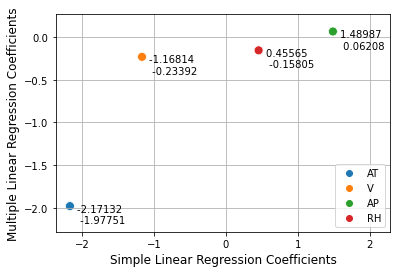

In [9]:
# print(columnsL[:len(columnsL)-1])
# print("Multiple Linear Regression", coef_multL)
# print("Simple Linear Regression", coef_simpL)

coef_multL = list(results.params[1:])
coef_multL = [round(coef, 5) for coef in coef_multL]

df = pd.DataFrame()
df["Feature"] = columnsL[:len(columnsL)-1]
df["simple"] = coef_simpL
df["multiple"] = coef_multL

# fig, ax = plt.subplots()
# fig.set_size_inches(19, 11)
# plt.tick_params(labelsize=15)

sns.scatterplot(x="simple", y="multiple", data=df, s=80, hue="Feature")

plt.xlabel("Simple Linear Regression Coefficients", fontsize=12)
plt.ylabel("Multiple Linear Regression Coefficients", fontsize=12)
plt.legend(loc="lower right")
plt.grid(True)
plt.xlim(min(coef_simpL)-.2, max(coef_simpL)+.8)
plt.ylim(min(coef_multL)-.3, max(coef_multL)+.2)

# the x, y coorindates are read top-down
for x, y in zip(coef_simpL, coef_multL):
    plt.text(x=x+.1, y=y-.2, s="{} \n {}".format(x, y))

plt.show()


>The magnitude of the coefficients for all predictors is noticably (and understandably) lower in the multiple regression model compared to it's simple regression counterpart. <br>
>The feature that has the greatest effect on the dependent variable (PE) -- ie the one with the highest coefficient -- is still AT. <br>
>It also had the smallest change. This makes sense since the simple linear regression model with AT as the sole predictor had the highest R² at almost 0.9 -- compared to the other simple regressions. <br>
>Among the simple model, the one for predictor V had the second highest R², but it's coefficient's magnitude decrease a lot. It is possible that this is due to some multicollinearity between AT and V, since as we noticed in 1.b.ii their is positive correlation between the two. <br>
>One peculiar difference, is that the sign of RH's coefficient changed from positive to negative, even though both were statistically significant for their respective models.

-----------------
## 1.f
(f) Is there evidence of nonlinear association between any of the predictors and the response? To answer this question, for each predictor X, fit a model of the form:
Y = β₀ + β₁X + β₂X² + β₃X³ + ε 

In [10]:
# https://scikit-learn.org/stable/modules/preprocessing.html#generating-polynomial-features
# https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html#sklearn.preprocessing.PolynomialFeatures


# trainX_list = [trainX_AT, trainX_V, trainX_AP, trainX_RH]

for trainX in trainX_list:

    new_trainX = np.reshape(list(trainX), (-1,1))

    poly = PolynomialFeatures(degree=3)
    trainX_poly = poly.fit_transform((new_trainX))
    # don't need to add intercept since the function handles that

    # creating linear regression model
    model = sm.OLS(trainY_PE, trainX_poly)
    results = model.fit()
    
    name = trainX.name
    print("Cubic Polynomial Regression results between independent variable", trainX.name, "and dependent variable", trainY_PE.name)
    display(results.summary(xname=["const", name, "%s²" %name, "%s³" %name]))
    print("-------------------------------------------------------------------------\n")



Cubic Polynomial Regression results between independent variable AT and dependent variable PE


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     PE   R-squared:                       0.912
Model:                            OLS   Adj. R-squared:                  0.912
Method:                 Least Squares   F-statistic:                 3.299e+04
Date:                Fri, 24 Sep 2021   Prob (F-statistic):               0.00
Time:                        16:51:07   Log-Likelihood:                -29101.
No. Observations:                9568   AIC:                         5.821e+04
Df Residuals:                    9564   BIC:                         5.824e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        492.7281      0.673    732.248      0.000     491.409     494.047
AT            -0.6103      0.124     -4.941      0.000      -0.852      -0.368
AT²           -0.1251      0.007    -18.199      0.000      -0.139      -0.112
AT³            0.0027      0.000     22.594      0.000       0.002       0.003
==============================================================================
Omnibus:                      648.041   Durbin-Watson:                   2.033
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2767.059
Skew:                          -0.191   Prob(JB):                         0.00
Kurtosis:                       5.607   Cond. No.                     1.90e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.9e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

-------------------------------------------------------------------------

Cubic Polynomial Regression results between independent variable V and dependent variable PE


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     PE   R-squared:                       0.775
Model:                            OLS   Adj. R-squared:                  0.775
Method:                 Least Squares   F-statistic:                 1.098e+04
Date:                Fri, 24 Sep 2021   Prob (F-statistic):               0.00
Time:                        16:51:07   Log-Likelihood:                -33585.
No. Observations:                9568   AIC:                         6.718e+04
Df Residuals:                    9564   BIC:                         6.721e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        554.1468      9.151     60.557      0.000     536.209     572.084
V             -2.1444      0.509     -4.214      0.000      -3.142      -1.147
V²            -0.0027      0.009     -0.294      0.768      -0.021       0.015
V³             0.0001   5.45e-05      2.465      0.014    2.75e-05       0.000
==============================================================================
Omnibus:                      160.101   Durbin-Watson:                   2.009
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              279.778
Skew:                          -0.125   Prob(JB):                     1.77e-61
Kurtosis:                       3.800   Cond. No.                     2.47e+07
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.47e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

-------------------------------------------------------------------------

Cubic Polynomial Regression results between independent variable AP and dependent variable PE


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     PE   R-squared:                       0.275
Model:                            OLS   Adj. R-squared:                  0.275
Method:                 Least Squares   F-statistic:                     1813.
Date:                Fri, 24 Sep 2021   Prob (F-statistic):               0.00
Time:                        16:51:07   Log-Likelihood:                -39184.
No. Observations:                9568   AIC:                         7.837e+04
Df Residuals:                    9565   BIC:                         7.840e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0747      0.009      8.415      0.000       0.057       0.092
AP            25.2556      3.001      8.415      0.000      19.372      31.139
AP²           -0.0500      0.006     -8.439      0.000      -0.062      -0.038
AP³         2.514e-05   2.92e-06      8.613      0.000    1.94e-05    3.09e-05
==============================================================================
Omnibus:                      556.766   Durbin-Watson:                   1.997
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              640.319
Skew:                           0.621   Prob(JB):                    9.05e-140
Kurtosis:                       2.751   Cond. No.                     2.12e+15
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.12e+15. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

-------------------------------------------------------------------------

Cubic Polynomial Regression results between independent variable RH and dependent variable PE


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     PE   R-squared:                       0.154
Model:                            OLS   Adj. R-squared:                  0.153
Method:                 Least Squares   F-statistic:                     579.2
Date:                Fri, 24 Sep 2021   Prob (F-statistic):               0.00
Time:                        16:51:07   Log-Likelihood:                -39923.
No. Observations:                9568   AIC:                         7.985e+04
Df Residuals:                    9564   BIC:                         7.988e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        468.4135     10.545     44.422      0.000     447.744     489.083
RH            -1.7292      0.486     -3.557      0.000      -2.682      -0.776
RH²            0.0321      0.007      4.433      0.000       0.018       0.046
RH³           -0.0002   3.51e-05     -4.340      0.000      -0.000   -8.34e-05
==============================================================================
Omnibus:                      707.867   Durbin-Watson:                   1.998
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              302.057
Skew:                           0.223   Prob(JB):                     2.56e-66
Kurtosis:                       2.253   Cond. No.                     3.26e+07
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.26e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

-------------------------------------------------------------------------



><b>For cubic polynomial regression with predictor AT, there is evidence of nonlinear association between the predictor and response (PE).</b> <br>
> The p-value of AT² and AT³ is both ~0.000. <br>
>Since ~0.000 < 0.05 (which is a common standard for the significance level), we can reject the null and say that there is a statistically significant nonlinear association between AT and PE.

><b>For cubic polynomial regression with predictor V, there is evidence of nonlinear association between the predictor and response (PE).</b> <br>
> The p-value of V² is 0.768 and of V³ is 0.014. <br>
>The effect of V² is insignificant; however, since ~0.014 < 0.05 (which is a common standard for the significance level), we can reject the null for V³ and say that there is a statistically significant nonlinear association between V and PE.

><b>For cubic polynomial regression with predictor AP, there is evidence of nonlinear association between the predictor and response (PE).</b> <br>
> The p-value of AP² and AP³ is both ~0.000. <br>
>Since ~0.000 < 0.05 (which is a common standard for the significance level), we can reject the null and say that there is a statistically significant nonlinear association between AP and PE.

><b>For cubic polynomial regression with predictor RH, there is evidence of nonlinear association between the predictor and response (PE).</b> <br>
> The p-value of RH² and RH³ is both ~0.000. <br>
>Since ~0.000 < 0.05 (which is a common standard for the significance level), we can reject the null and say that there is a statistically significant nonlinear association between RH and PE.


-------------
## 1.g
(g) Is there evidence of association of interactions of predictors with the response? To answer this question, run a full linear regression model with all pairwise interaction terms and state whether any interaction terms are statistically significant.

In [11]:
# I used the commented out code below to check that the smf formula method for pairwise interactions, yields accurate results
# It gave the same answers, as the manual method but is more efficient
# Could also use the sklearn PolynomialFeatures method by setting the parameter interaction_only=True
# uncomment lines below to see


# trainX_AT_V = trainX_AT * trainX_V.values

# trainX_int_df = pd.DataFrame()
# trainX_int_df["AT"] = trainX_AT
# trainX_int_df["V"] = trainX_V
# trainX_int_df["AT*V"] = trainX_AT_V

# # adding an intercept 
# trainX_int_df = sm.add_constant(trainX_int_df, prepend=True)

# # creating linear regression model
# model = sm.OLS(trainY_PE_df, trainX_int_df)
# results = model.fit()
# display(results.summary())

# print()

# pairwise_inter = "PE ~ AT + V + AT*V"
# model = smf.ols(formula = pairwise_inter, data = ccpp_df)
# results = model.fit()
# display(results.summary())


In [12]:
# https://www.statsmodels.org/dev/example_formulas.html

pairwise_interact = "PE ~ AT + V + AP + RH + AT*V + AT*AP + AT*RH + V*AP + V*RH + AP*RH"
model = smf.ols(formula = pairwise_interact, data = ccpp_df)
results = model.fit()
display(results.summary())
# in the output and markdown below, the ":" between the variable names represents multiplication "*"


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     PE   R-squared:                       0.936
Model:                            OLS   Adj. R-squared:                  0.936
Method:                 Least Squares   F-statistic:                 1.405e+04
Date:                Fri, 24 Sep 2021   Prob (F-statistic):               0.00
Time:                        16:51:07   Log-Likelihood:                -27548.
No. Observations:                9568   AIC:                         5.512e+04
Df Residuals:                    9557   BIC:                         5.520e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    685.7825     78.640      8.721      0.000     531.631     839.934
AT            -4.3470      2.373     -1.832      0.067      -8.999       0.305
V             -7.6749      1.351     -5.682      0.000     -10.323      -5.027
AP            -0.1524      0.077     -1.983      0.047      -0.303      -0.002
RH             1.5709      0.773      2.031      0.042       0.055       3.087
AT:V           0.0210      0.001     23.338      0.000       0.019       0.023
AT:AP          0.0018      0.002      0.752      0.452      -0.003       0.006
AT:RH         -0.0052      0.001     -6.444      0.000      -0.007      -0.004
V:AP           0.0068      0.001      5.135      0.000       0.004       0.009
V:RH           0.0008      0.000      1.716      0.086      -0.000       0.002
AP:RH         -0.0016      0.001     -2.125      0.034      -0.003      -0.000
==============================================================================
Omnibus:                     1454.609   Durbin-Watson:                   2.030
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             9170.848
Skew:                          -0.574   Prob(JB):                         0.00
Kurtosis:                       7.657   Cond. No.                     1.70e+08
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.7e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

><b>For the multiple linear regression with all pairwise interaction, there is evidence for association between interactions of predictors with the response variable (PE).</b> <br>
>The p-values of interactions AT:V, AT:RH, and V:AP are ~0.000. <br>
>Since ~0.000 < 0.05 (or even a much stricter significance level), we can reject the null and say that there is a statistically significant  association between the predictor interactions and PE.<br>
>Also, the p-value of interaction AP:RH is ~0.034. <br>
>Since ~0.000 < 0.05 (which is a common standard for the significance level), we can reject the null and say that there is a statistically significant association between interaction AP:RH and PE.
>As an extra point, the p-value of interaction V:RH is ~0.086. <br>
>If we use a more lenient (but often used) confidience level of 90%, we can reject the null and say that there is a statistically significant association between interaction V:RH and PE -- since ~0.086 < 0.10. <br>
><b>Either way, we see that there is evidence for association between interactions of predictors with the response. </b>

---------
## 1.h
(h) Can you improve your model using possible interaction terms or nonlinear asso- ciations between the predictors and response? Train the regression model on a randomly selected 70% subset of the data with all predictors. Also, run a regres- sion model involving all possible interaction terms and quadratic nonlinearities, and remove insignificant variables using p-values (be careful about interaction terms). Test both models on the remaining points and report your train and test MSEs.

In [13]:
# randomize the dataset -- using the sample() method

# paramter frac = 1 indicates to return all rows rathers than some sample fraction 
# if random_state is set to a particular integer, it will return same randomized rows as the sample in every iteration -- maintaining reproducability of the random sample
# Although it is considering a pseudo-randomization, I used the random_state parameter
# Otherwise, it would cause inconsistent results and possibly inaccurate markdown responses; there could be significant variation in feature significance and model errors depending on the sample
# The paramter should be removed, if you want changing random samples
ccpp_rand_df = ccpp_df.sample(frac = 1, random_state = 3)

# divide the entire dataset into seperate training and testing sets
frac = round(n*.7)
# since 70% of the dataset isn't a whole number, so we use round()

train_set_df = ccpp_rand_df[:frac]
test_set_df = ccpp_rand_df[frac:]

# display(ccpp_df)
# display(train_set_df)
# display(test_set_df)


In [14]:
# Model 1: baseline model trained on 70% of the dataset

# this redefines the variables, but it's ok since we won't be using the 100% training set anymore
trainY_PE = train_set_df["PE"]
trainX_all = train_set_df[["AT", "V", "AP", "RH"]]

# adding an intercept 
trainX_all_const = sm.add_constant(trainX_all, prepend=True)

# creating linear regression model
model = sm.OLS(trainY_PE, trainX_all_const)
results = model.fit()
display(results.summary())

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     PE   R-squared:                       0.929
Model:                            OLS   Adj. R-squared:                  0.929
Method:                 Least Squares   F-statistic:                 2.205e+04
Date:                Fri, 24 Sep 2021   Prob (F-statistic):               0.00
Time:                        16:51:07   Log-Likelihood:                -19616.
No. Observations:                6698   AIC:                         3.924e+04
Df Residuals:                    6693   BIC:                         3.928e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        458.2519     11.583     39.564      0.000     435.547     480.957
AT            -1.9774      0.018   -109.205      0.000      -2.013      -1.942
V             -0.2404      0.009    -27.814      0.000      -0.257      -0.223
AP             0.0589      0.011      5.237      0.000       0.037       0.081
RH            -0.1589      0.005    -32.104      0.000      -0.169      -0.149
==============================================================================
Omnibus:                      588.225   Durbin-Watson:                   1.973
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2615.512
Skew:                          -0.326   Prob(JB):                         0.00
Kurtosis:                       5.991   Cond. No.                     2.13e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.13e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [15]:
testY_PE = test_set_df["PE"]
testX_all = test_set_df[["AT", "V", "AP", "RH"]]
# adding an intercept 
testX_all_const = sm.add_constant(testX_all, prepend=True)

# https://www.statsmodels.org/stable/dev/generated/statsmodels.base.model.Results.predict.html
# Creating predictions for the response variable based on feature data
train_predY = results.predict(trainX_all_const)
test_predY = results.predict(testX_all_const)

# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_error.html

# calculating the error
train_mse = round(mean_squared_error(trainY_PE, train_predY), 5)
test_mse = round(mean_squared_error(testY_PE, test_predY), 5)

print("The training set's MSE for a multiple linear regression model with all 4 predictors is:", train_mse)
print("The testing set's MSE for a multiple linear regression model with all 4 predictors is:", test_mse)


The training set's MSE for a multiple linear regression model with all 4 predictors is: 20.47897
The testing set's MSE for a multiple linear regression model with all 4 predictors is: 21.46333


In [16]:
# Model 2: model with all features interactions and quadratic nonlinearities 70% of the dataset
# could use the smf ~ formula method, or the poly method; smf method looks/is more efficient

# smf ~ formula method
form = "PE ~ AT + V + AP + RH + np.power(AT,2) + np.power(V,2) + np.power(AP,2) + np.power(RH,2) + AT*V + AT*AP + AT*RH + V*AP + V*RH + AP*RH"
model = smf.ols(formula = form, data = train_set_df)
results = model.fit()

namesL = ["const", "AT", "V", "AP", "RH", "AT²", "V²", "AP²", "RH²", "AT*V", "AT*AP", "AT*RH", "V*AP", "V*RH", "AP*RH"]
display(results.summary(xname = namesL))


# Finding the MSEs
# https://www.statsmodels.org/stable/dev/generated/statsmodels.base.model.Results.predict.html
train_predY = results.predict(trainX_all_const)
test_predY = results.predict(testX_all_const)

# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_error.html

train_mse = round(mean_squared_error(trainY_PE, train_predY), 5)
test_mse = round(mean_squared_error(testY_PE, test_predY), 5)

print("The training set's MSE for a multiple linear regression model with all 4 predictors and all of its interation terms and quadratic nonlinearities is:", train_mse)
print("The testing set's MSE for a multiple linear regression model with all 4 predictors and all of its interation terms and quadratic nonlinearities is:", test_mse)



# uncomment lines below to use the polynomial features method instead; and comment out lines above
# # poly method
# poly = PolynomialFeatures(degree=2)
# # adds the pairwise interactions and quadratic polynomials of the features to the dataset
# trainX_poly = poly.fit_transform((trainX_all))
# testX_poly = poly.fit_transform((testX_all))
# # don't need to add intercept since the function handles that

# # creating linear regression model
# model = sm.OLS(trainY_PE, trainX_poly)
# results = model.fit()

# namesL = poly.get_feature_names(trainX_all.columns)
# namesL[0] = "const"
# namesL = [name.replace(" ", "*") for name in namesL]
# display(results.summary(xname=namesL))


# # Finding the MSEs
# # https://www.statsmodels.org/stable/dev/generated/statsmodels.base.model.Results.predict.html
# train_predY = results.predict(trainX_poly)
# test_predY = results.predict(testX_poly)

# # https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_error.html
# from sklearn.metrics import mean_squared_error

# train_mse = round(mean_squared_error(trainY_PE, train_predY), 5)
# test_mse = round(mean_squared_error(testY_PE, test_predY), 5)

# print("The training set's MSE for a multiple linear regression model with all 4 predictors and all of its interation terms and quadratic nonlinearities is:", train_mse)
# print("The testing set's MSE for a multiple linear regression model with all 4 predictors and all of its interation terms and quadratic nonlinearities is:", test_mse)



<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     PE   R-squared:                       0.939
Model:                            OLS   Adj. R-squared:                  0.938
Method:                 Least Squares   F-statistic:                     7293.
Date:                Fri, 24 Sep 2021   Prob (F-statistic):               0.00
Time:                        16:51:08   Log-Likelihood:                -19153.
No. Observations:                6698   AIC:                         3.834e+04
Df Residuals:                    6683   BIC:                         3.844e+04
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -8619.5723   1449.302     -5.947      0.000   -1.15e+04   -5778.479
AT            -5.2607      3.636     -1.447      0.148     -12.388       1.867
V             -3.6110      1.781     -2.028      0.043      -7.102      -0.120
AP            17.8349      2.811      6.345      0.000      12.325      23.345
RH             4.1199      1.032      3.992      0.000       2.097       6.143
AT²            0.0156      0.004      4.312      0.000       0.009       0.023
V²            -0.0008      0.001     -0.840      0.401      -0.003       0.001
AP²           -0.0087      0.001     -6.380      0.000      -0.011      -0.006
RH²           -0.0017      0.000     -5.553      0.000      -0.002      -0.001
AT*V           0.0121      0.003      3.764      0.000       0.006       0.018
AT*AP          0.0026      0.004      0.728      0.467      -0.004       0.010
AT*RH         -0.0056      0.002     -3.195      0.001      -0.009      -0.002
V*AP           0.0031      0.002      1.781      0.075      -0.000       0.006
V*RH           0.0003      0.001      0.358      0.720      -0.001       0.002
AP*RH         -0.0038      0.001     -3.852      0.000      -0.006      -0.002
==============================================================================
Omnibus:                     1026.118   Durbin-Watson:                   1.978
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             6240.740
Skew:                          -0.589   Prob(JB):                         0.00
Kurtosis:                       7.580   Cond. No.                     2.89e+10
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.89e+10. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

The training set's MSE for a multiple linear regression model with all 4 predictors and all of its interation terms and quadratic nonlinearities is: 17.83596
The testing set's MSE for a multiple linear regression model with all 4 predictors and all of its interation terms and quadratic nonlinearities is: 18.77161


>In the model above, the insignificant variables (based on a standard significance level of 0.05) are AT, V², AT* AP, V* AP, and V* RH. <br>
>However, I decided to only remove V² and the interaction terms AT* AP and V* RH. <br>
>Firstly, since we are including interaction terms of predictor V (ie AT* V), we must keep its main effects -- which includes predictor V -- per the hierarchical principal. Otherwise, interpretting the related interaction terms would be very hard, among other things. <br>
>Regarding V* AP, since we can consider it statistically significant if we use the more lenient level of doubt 0.10, I thought it would be better not to remove it -- especially since excluding its three related terms (V², AT* AP and V* RH) may improve V* AP's p-value in the new model, such as due to multicollinearity. <br>
>So, technically, I am doing a pruning of this model based on a 90% confidence level.

Note: the model above can change quite a bit with a different random sample, making the pruning below less accurate.

In [17]:
# removing insignificant features/interactions/polynomials
# TA Pratik said that "All the insignificant terms are to be prunes at once"; no need for backward elimination

# smf ~ formula method
# We simply exclude the insignificant features/interactions/polynomials from our formula "form"
form = "PE ~ AT + V + AP + RH + np.power(AT,2) + np.power(AP,2) + np.power(RH,2) + AT*V + AT*RH + V*AP + AP*RH"
model = smf.ols(formula = form, data = train_set_df)
results = model.fit()

namesL = ["const", "AT", "V", "AP", "RH", "AT²", "AP²", "RH²", "AT*V", "AT*RH", "V*AP", "AP*RH"]
display(results.summary(xname = namesL))

# Finding the MSEs
train_predY = results.predict(trainX_all_const)
test_predY = results.predict(testX_all_const)

train_mse = round(mean_squared_error(trainY_PE, train_predY), 5)
test_mse = round(mean_squared_error(testY_PE, test_predY), 5)

print("The training set's MSE for a multiple linear regression model with all 4 predictors and pruned interation terms and quadratic nonlinearities is:", train_mse)
print("The testing set's MSE for a multiple linear regression model with all 4 predictors and pruned interation terms and quadratic nonlinearities is:", test_mse)



# uncomment lines below to use the polynomial features method -- IF you used poly method in cell above; and comment out lines above
# # poly method
# # convert numpy arrays to dataframe
# trainX_poly_df = pd.DataFrame(trainX_poly)
# testX_poly_df = pd.DataFrame(testX_poly)
# # drop the insignificant features
# trainX_poly_df = trainX_poly_df.drop([7, 9, 11], axis=1)
# testX_poly_df = testX_poly_df.drop([7, 9, 11], axis=1)

# # creating regression model
# model = sm.OLS(trainY_PE, trainX_poly_df)
# results = model.fit()

# namesL = poly.get_feature_names(trainX_all.columns)
# namesL[0] = "const"
# namesL = [name.replace(" ", "*") for name in namesL]
# del namesL[11]
# del namesL[9]
# del namesL[7]
# display(results.summary(xname = namesL))


# # Finding the MSEs
# train_predY = results.predict(trainX_poly_df)
# test_predY = results.predict(testX_poly_df)

# train_mse = round(mean_squared_error(trainY_PE, train_predY), 5)
# test_mse = round(mean_squared_error(testY_PE, test_predY), 5)

# print("The training set's MSE for a multiple linear regression model with all 4 predictors and pruned interation terms and quadratic nonlinearities is:", train_mse)
# print("The testing set's MSE for a multiple linear regression model with all 4 predictors and pruned interation terms and quadratic nonlinearities is:", test_mse)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     PE   R-squared:                       0.939
Model:                            OLS   Adj. R-squared:                  0.938
Method:                 Least Squares   F-statistic:                     9284.
Date:                Fri, 24 Sep 2021   Prob (F-statistic):               0.00
Time:                        16:51:08   Log-Likelihood:                -19154.
No. Observations:                6698   AIC:                         3.833e+04
Df Residuals:                    6686   BIC:                         3.841e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -9236.8895   1265.369     -7.300      0.000   -1.17e+04   -6756.363
AT            -2.6045      0.112    -23.307      0.000      -2.824      -2.385
V             -4.5201      1.097     -4.120      0.000      -6.671      -2.369
AP            19.0147      2.463      7.720      0.000      14.186      23.843
RH             4.6115      0.820      5.621      0.000       3.003       6.220
AT²            0.0164      0.002      7.297      0.000       0.012       0.021
AP²           -0.0093      0.001     -7.722      0.000      -0.012      -0.007
RH²           -0.0017      0.000     -6.144      0.000      -0.002      -0.001
AT*V           0.0103      0.002      6.699      0.000       0.007       0.013
AT*RH         -0.0054      0.001     -5.859      0.000      -0.007      -0.004
V*AP           0.0040      0.001      3.685      0.000       0.002       0.006
AP*RH         -0.0043      0.001     -5.462      0.000      -0.006      -0.003
==============================================================================
Omnibus:                     1025.748   Durbin-Watson:                   1.978
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             6208.350
Skew:                          -0.590   Prob(JB):                         0.00
Kurtosis:                       7.567   Cond. No.                     2.53e+10
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.53e+10. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

The training set's MSE for a multiple linear regression model with all 4 predictors and pruned interation terms and quadratic nonlinearities is: 17.83992
The testing set's MSE for a multiple linear regression model with all 4 predictors and pruned interation terms and quadratic nonlinearities is: 18.78752


>We definitely improved our model by using interaction terms and nonlinear associations between the predictors and response variable. <br>
>This can be clearly seen with how the test MSE decreased from 21.46333 to 17.83596. <br>
>Surprisingly, the pruned model did not have a better MSE. Although, I found that this too varies depending on the random sample being using.

-----------
## 1.i
(i) KNN Regression:
Perform k-nearest neighbor regression for this dataset using both normalized and raw features. Find the value of k ∈ {1,2,...,100} that gives you the best fit. Plot the train and test errors in terms of 1/k.

In [18]:
# https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsRegressor.html

# KNN Regression with raw features

k_vals = list(range(1, 101, 1))
x_axis = [1/k for k in k_vals]

train_mseL = []
test_mseL = []

for k in k_vals:
    # construct the model and specify the paramters 
    model = KNeighborsRegressor(n_neighbors=k)
    # train/fit our model with the training set data
    model.fit(trainX_all, trainY_PE)
    
    # get prediction of target variable (PE) from training set features -- based based on training set fit
    train_predY = model.predict(trainX_all)
    # get prediction of target variable (PE) from testing set features -- based based on training set fit
    test_predY = model.predict(testX_all)
    
    # calculate the train and test errors
    train_mse = round(mean_squared_error(trainY_PE, train_predY), 5)
    train_mseL.append(train_mse)
    test_mse = round(mean_squared_error(testY_PE, test_predY), 5)
    test_mseL.append(test_mse)

# initializing best_k such that the while loop starts
best_k = 1
# Was told that 1 cannot be a valid k* since its using itself as a neighbor; need to exclude the possibility k* = 1
while best_k == 1:
    best_test_mse = min(test_mseL)
    best_k = k_vals[test_mseL.index(best_test_mse)]
    optK_train_mse = train_mseL[test_mseL.index(best_test_mse)]
    if 1 in k_vals: k_vals.remove(1)
# need to return the 1, since k_vals is often reused without being redefined
k_vals.insert(len(k_vals), 1)

# print("The best train MSE is", best_train_mse)
# print("The best test MSE (and thus fit) is", best_test_mse, "at k =", best_k)
    

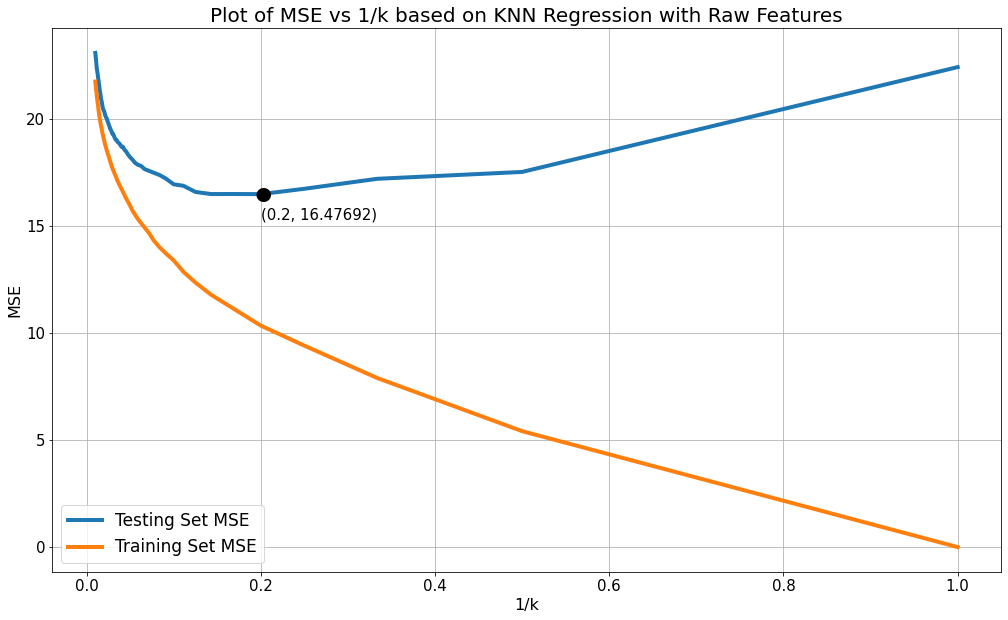

The best test MSE (and thus fit) is 16.47692 at k* = 5
The train MSE at k* = 5 is 10.33894


In [19]:
# Line graph of the training and testing MSE in terms of k for k ∈ {1,2,...,100}

# setting plot size
fig, ax = plt.subplots()
fig.set_size_inches(17, 10)

plt.plot(x_axis, test_mseL, linewidth=4)
plt.plot(x_axis, train_mseL, linewidth=4)
plt.xlabel("1/k", fontsize=16)
plt.ylabel("MSE", fontsize=16)
plt.legend(["Testing Set MSE", "Training Set MSE"], fontsize=17)
plt.tick_params(labelsize=15)
plt.grid(True)
plt.text(x=1/best_k-.014, y=best_test_mse-.9, s="•", fontsize=50)
plt.text(x=1/best_k, y=best_test_mse-1.2, s=(round(1/best_k, 5), best_test_mse), fontsize=15)
plt.title("Plot of MSE vs 1/k based on KNN Regression with Raw Features", fontsize=20)

plt.show()

print("The best test MSE (and thus fit) is", best_test_mse, "at k* =", best_k)
print("The train MSE at k* =", best_k, "is", optK_train_mse)



In [20]:
# https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html
# https://towardsdatascience.com/everything-you-need-to-know-about-min-max-normalization-in-python-b79592732b79

scaler = MinMaxScaler()
# fit scaler using the train set
scaler.fit(trainX_all)
# normalize the training sets's features
trainX_norm = scaler.transform(trainX_all)

# fit scaler using the test set
scaler.fit(testX_all)
# normalize the training sets's features
testX_norm = scaler.transform(testX_all)

# in the two cells below, we pretty much just repeat the 2 python cells above


In [21]:
# https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsRegressor.html
# KNN Regression with normalized features

k_vals = list(range(1, 101, 1))
x_axis = [1/k for k in k_vals]

train_mseL = []
test_mseL = []

for k in k_vals:
    # construct the model and specify the paramters 
    model = KNeighborsRegressor(n_neighbors=k)
    # train/fit our model with the training set data
    model.fit(trainX_norm, trainY_PE)
    
    # get prediction of target variable (PE) from training set features -- based based on training set fit
    train_predY = model.predict(trainX_norm)
    # get prediction of target variable (PE) from testing set features -- based based on training set fit
    test_predY = model.predict(testX_norm)
    
    # calculate the train and test errors
    train_mse = round(mean_squared_error(trainY_PE, train_predY), 5)
    train_mseL.append(train_mse)
    test_mse = round(mean_squared_error(testY_PE, test_predY), 5)
    test_mseL.append(test_mse)

# initializing best_k such that the while loop starts
best_k = 1
# Was told that 1 cannot be a valid k* since its using itself as a neighbor; need to exclude the possibility k* = 1
while best_k == 1:
    best_test_mse = min(test_mseL)
    best_k = k_vals[test_mseL.index(best_test_mse)]
    optK_train_mse = train_mseL[test_mseL.index(best_test_mse)]
    if 1 in k_vals: k_vals.remove(1)
# need to return the 1, since k_vals is often reused without being redefined
k_vals.insert(len(k_vals), 1)

# print("The best train MSE is", best_train_mse)
# print("The best test MSE (and thus fit) is", best_test_mse, "at k =", best_k)
    

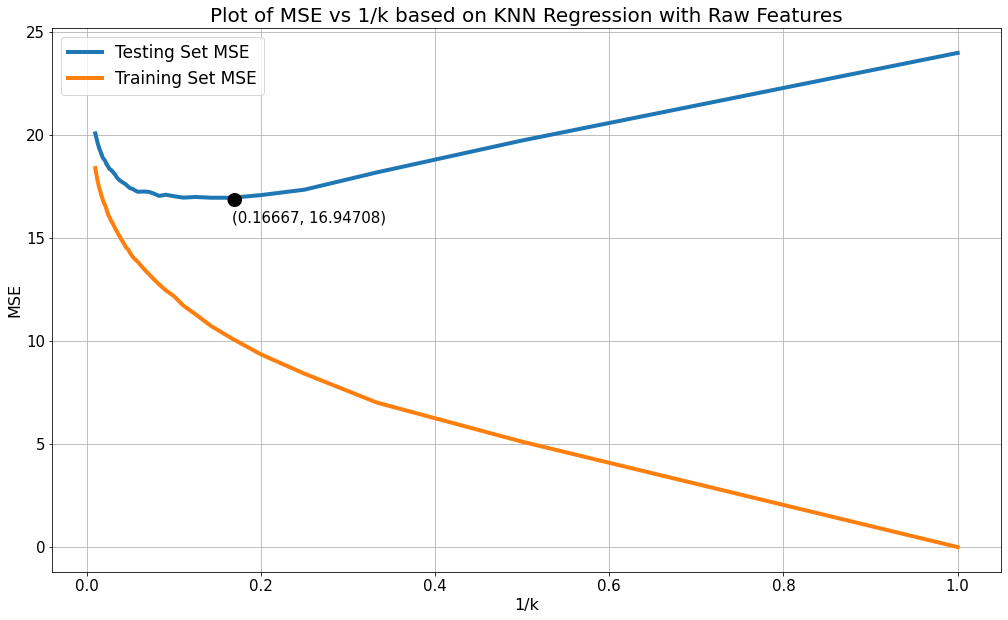

The best test MSE (and thus fit) is 16.94708 at k = 6
The train MSE at k* = 6 is 10.12346


In [22]:
# Line graph of the training and testing MSE in terms of k for k ∈ {1,2,...,100}

# setting plot size
fig, ax = plt.subplots()
fig.set_size_inches(17, 10)

plt.plot(x_axis, test_mseL, linewidth=4)
plt.plot(x_axis, train_mseL, linewidth=4)
plt.xlabel("1/k", fontsize=16)
plt.ylabel("MSE", fontsize=16)
plt.legend(["Testing Set MSE", "Training Set MSE"], fontsize=17)
plt.tick_params(labelsize=15)
plt.grid(True)
plt.text(x=1/best_k-.014, y=best_test_mse-1, s="•", fontsize=50)
plt.text(x=1/best_k, y=best_test_mse-1.2, s=(round(1/best_k, 5), best_test_mse), fontsize=15)
plt.title("Plot of MSE vs 1/k based on KNN Regression with Raw Features", fontsize=20)

plt.show()

print("The best test MSE (and thus fit) is", best_test_mse, "at k =", best_k)
print("The train MSE at k* =", best_k, "is", optK_train_mse)


----------
## 1.j
(j) Compare the results of KNN Regression with the linear regression model that has the smallest test error and provide your analysis.

In [23]:
knn_raw = ["10.33894", "16.47692"]
knn_norm = ["10.12346", "16.94708"]
lin_best = ["17.83596", "18.77161"]

compar_df = pd.DataFrame()
compar_df["Quad Poly Reg"] = lin_best
compar_df["KNN Reg raw"] = knn_raw
compar_df["KNN Reg norm"] = knn_norm
compar_df = compar_df.rename(index={0: "Training MSE", 1: "Testing MSE"})

display(compar_df)

# If you change the random_state, this output won't be accurate since its values are hardcoded


Quad Poly Reg KNN Reg raw KNN Reg norm
Training MSE      17.83596    10.33894     10.12346
Testing MSE       18.77161    16.47692     16.94708

Not using the current random_state would cause inconsistent results and possibly inaccurate markdown responses; there could be significant variation in feature significance and model errors depending on the sample.


>For this CCPP data (and this random sample), KNN regression appears to provide a better fit -- as is shown by the lower MSE. <br>
>A scenario where KNN regression has a better performance than linear regression is when the data set has a high signal-to-noise ratio. It is possible, this is such a case. <br>
>Regarding the two KNN models, the raw one provided a better test MSE than the model that used a normalized dataset. Based on the professor's previous statements, this isn't surprising.


In [24]:
# https://towardsdatascience.com/comparative-study-on-classic-machine-learning-algorithms-24f9ff6ab222


-------------
## 2.a
ISLR: 2.4.1

For each of parts (a) through (d), indicate whether we would generally expect the performance of a flexible statistical learning method to be better or worse than an inflexible method. Justify your answer.

(a) The sample size n is extremely large, and the number of predictors p is small.

>High bias means an underfit model, and high variance means an overfit model. We want to find the sweet spot of bias-variance trade-off -- such that our model can generalize as accurately as possible.

>Flexible models tend to decrease bias, but also have a higher risk of overfitting.

>Additionally, a small sample size (n) and/or large number of predictors (p), is commonly associated with overfitting.

>Therefore, in this case, an extremely large n and a small number of features makes the likelihood of a model overfitting lower -- even with if we a flexible method.

>So here, with the benefit of low bias and reduced risk of overfitting, we would generally expect the performance of a flexible statistical learning method to be <b>BETTER</b>.

----------
## 2.b
ISLR: 2.4.1

For each of parts (a) through (d), indicate whether we would generally expect the performance of a flexible statistical learning method to be better or worse than an inflexible method. Justify your answer.

(b) The number of predictors p is extremely large, and the number of observations n is small.

>High bias means an underfit model, and high variance means an overfit model. We want to find the sweet spot of bias-variance trade-off -- such that our model can generalize as accurately as possible.

>Flexible models tend to decrease bias, but also have a higher risk of overfitting.

>Additionally, a small sample size (n) and/or large number of predictors (p), is commonly associated with overfitting.

>Therefore, in this case, having an extremely large number of predictors (p) and small n makes the likelihood of a flexible model overfitting to be extremely high.

>So here, we would generally expect the performance of a flexible statistical learning method to be <b>WORSE</b> than an inflexible method.

----------
## 2.c
ISLR: 2.4.1

For each of parts (a) through (d), indicate whether we would generally expect the performance of a flexible statistical learning method to be better or worse than an inflexible method. Justify your answer.

(c) The relationship between the predictors and response is highly non-linear.

>As a general rule of thumb, non-flexible models are linear and flexible models are non-linear.

>Therefore, a flexible model will generally perform <b>BETTER</b> when there is a nonlinear associations between the predictors and response variable.


----------
## 2.d
ISLR: 2.4.1

For each of parts (a) through (d), indicate whether we would generally expect the performance of a flexible statistical learning method to be better or worse than an inflexible method. Justify your answer.

(d) The variance of the error terms, i.e. σ² = Var(ε), is extremely high.

>High bias means an underfit model, and high variance means an overfit model. We want to find the sweet spot of bias-variance trade-off -- such that our model can generalize as accurately as possible.

>Flexible models tend to decrease bias, but also have a higher risk of overfitting.

>Having extremely high variance of the error terms means that our dataset has a lot of noise.

>Therefore, a flexible statistical learning method, which is prone to overfitting, will generally do <b>WORSE</b> than an inflexible method -- since it will also fit/capture the noise and become unable to generalize. 

--------------
## 3.a

The table below provides a training data set containing six observations, three predictors, and one qualitative response variable.

In [25]:
table = [[0,3,0,"Red"], [2,0,0,"Red"], [0,1,3,"Red"], [0,1,2,"Green"], [-1,0,1,"Green"], [1,1,1,"Red"]]

table_df = pd.DataFrame(table, index=[1,2,3,4,5,6], columns=["X₁", "X₂", "X₃", "Y"])
display(table_df)

X₁  X₂  X₃      Y
1   0   3   0    Red
2   2   0   0    Red
3   0   1   3    Red
4   0   1   2  Green
5  -1   0   1  Green
6   1   1   1    Red

ISLR: 2.4.7

Suppose we wish to use this data set to make a prediction for Y when X₁ = X₂ = X₃ = 0 using K-nearest neighbors.

(a) Compute the Euclidean distance between each observation and the test point, X₁ = X₂ = X₃ = 0.

In [26]:
# https://www.delftstack.com/howto/numpy/calculate-euclidean-distance/

test_point = [0, 0, 0]

# list of the observations (without the response variable)
obsL = [obs[:-1] for obs in table]

distL = []

for obs in obsL:
    # Euclidean distance is a straight line -- which may be found using the Pythagorean theorem
    # In this case the 3d pythagorean theorem: d² = X₁²+X₂²+X₃²
    dist = distan.euclidean(obs, test_point)
    distL.append(dist)

table_df["Euclid. Dist. (0, 0, 0)"] = distL
display(table_df)


X₁  X₂  X₃      Y  Euclid. Dist. (0, 0, 0)
1   0   3   0    Red                 3.000000
2   2   0   0    Red                 2.000000
3   0   1   3    Red                 3.162278
4   0   1   2  Green                 2.236068
5  -1   0   1  Green                 1.414214
6   1   1   1    Red                 1.732051

---------
## 3.b
ISLR: 2.4.7

Suppose we wish to use this data set to make a prediction for Y when X₁ = X₂ = X₃ = 0 using K-nearest neighbors.

(b) What is our prediction with K = 1? Why?

>With KNN classification, we determine an observation's predicted class (ie the categorical response value) based on the label of its K-nearest neighbors.

>At K=1, we see from the table in 3.a that the nearest neighbor -- based on based on Euclidean distance -- is observation 5.

>So, our prediction for the test point is "Green".

---------
## 3.c
ISLR: 2.4.7

Suppose we wish to use this data set to make a prediction for Y when X₁ = X₂ = X₃ = 0 using K-nearest neighbors.

(c) What is our prediction with K = 3? Why?

>With KNN classification, we determine an observation's predicted class -- ie the categorical response value -- based on the label of its K-nearest neighbors.

>At K=3, we see from the table in 3.a that the 3 nearest neighbor -- based on based on Euclidean distance -- are observations 5 (Green), 6 (Red), and 2 (Red).

>So, with a probability of 2/3, our prediction for the test point is "Red".

---------
## 3.d
ISLR: 2.4.7

Suppose we wish to use this data set to make a prediction for Y when X₁ = X₂ = X₃ = 0 using K-nearest neighbors.

(d) If the Bayes decision boundary in this problem is highly non- linear, then would we expect the best value for K to be large or small? Why?

>We know that generally the higher the K, in other words the more neighbors that are considered, the more linear the decision boundary becomes.

>Conversely, a KNN model with a smaller K is more flexbility, and by extension has a more non-linear decision boundary.

>So, when the Bayes decision boundary is highly non-linear, we would expect the best value for K to be small.